## Imports

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from PIL import Image, ImageDraw, ImageFont, ImageOps

## Get Data

In [9]:

dialogue_df = pd.read_csv("data/The-Office-Lines.csv", index_col=["season", "episode"])
tokenizer = RegexpTokenizer(r'\w+')
dialogue_df["num_words"] = dialogue_df["line"].apply(lambda x: len(tokenizer.tokenize(x)))
dialogue_df

title  scene   speaker  \
season episode                            
1      1         Pilot      1   Michael   
       1         Pilot      1       Jim   
       1         Pilot      1   Michael   
       1         Pilot      1       Jim   
       1         Pilot      1   Michael   
...                ...    ...       ...   
9      24       Finale   7972     Creed   
       24       Finale   7973  Meredith   
       24       Finale   7974   Phyllis   
       24       Finale   7975       Jim   
       24       Finale   7976       Pam   

                                                             line  num_words  
season episode                                                                
1      1        All right Jim. Your quarterlies look very good...         14  
       1               Oh, I told you. I couldn't close it. So...         10  
       1        So you've come to the master for guidance? Is ...         16  
       1               Actually, you called me in here, but yeah.          8  
       1          All right. Well, let me show you how it's done.         11  
...                                                           ...        ...  
9      24       It all seems so very arbitrary. I applied for ...         56  
       24       I just feel lucky that I got a chance to share...         44  
       24       I'm happy that this was all filmed so I can re...         32  
       24       I sold paper at this company for 12 years. My ...         50  
       24       I thought it was weird when you picked us to m...         49  

[54167 rows x 5 columns]

## Fix wrong names in df

In [10]:
dialogue_df["speaker"] = dialogue_df["speaker"].apply(lambda w: w.strip()[:-1] if w.strip().endswith(":") else w)

## Get Main Characters

In [11]:
main_characters = dialogue_df["speaker"].value_counts().index[:16].tolist()

character_dict = {character:i for i, character in enumerate(main_characters)}
id_dict = {i:character for i, character in enumerate(main_characters)}

main_characters

['Michael',
 'Dwight',
 'Jim',
 'Pam',
 'Andy',
 'Angela',
 'Kevin',
 'Erin',
 'Oscar',
 'Ryan',
 'Darryl',
 'Phyllis',
 'Kelly',
 'Toby',
 'Jan',
 'Stanley']

In [12]:
dialogue_df

title  scene   speaker  \
season episode                            
1      1         Pilot      1   Michael   
       1         Pilot      1       Jim   
       1         Pilot      1   Michael   
       1         Pilot      1       Jim   
       1         Pilot      1   Michael   
...                ...    ...       ...   
9      24       Finale   7972     Creed   
       24       Finale   7973  Meredith   
       24       Finale   7974   Phyllis   
       24       Finale   7975       Jim   
       24       Finale   7976       Pam   

                                                             line  num_words  
season episode                                                                
1      1        All right Jim. Your quarterlies look very good...         14  
       1               Oh, I told you. I couldn't close it. So...         10  
       1        So you've come to the master for guidance? Is ...         16  
       1               Actually, you called me in here, but yeah.          8  
       1          All right. Well, let me show you how it's done.         11  
...                                                           ...        ...  
9      24       It all seems so very arbitrary. I applied for ...         56  
       24       I just feel lucky that I got a chance to share...         44  
       24       I'm happy that this was all filmed so I can re...         32  
       24       I sold paper at this company for 12 years. My ...         50  
       24       I thought it was weird when you picked us to m...         49  

[54167 rows x 5 columns]

## Make Interaction Graph

In [13]:
G = nx.Graph()

scene_before = ""
for i in range(len(dialogue_df)):

    # check if scene of text is the same
    if scene_before != dialogue_df["scene"].iloc[i]:
        scene_before = dialogue_df.iloc[i]["scene"]
        continue

    scene_before = dialogue_df.iloc[i]["scene"]

    # get characters
    c1 = dialogue_df["speaker"].iloc[i]
    c2 = dialogue_df["speaker"].iloc[i+1]

    if c1 not in main_characters or c2 not in main_characters:
        continue

    sorted_characters = sorted([c1, c2])
    try:
        G.edges[sorted_characters]["weight"] += 1
    except KeyError:
        G.add_edge(sorted_characters[0], sorted_characters[1], weight=1)

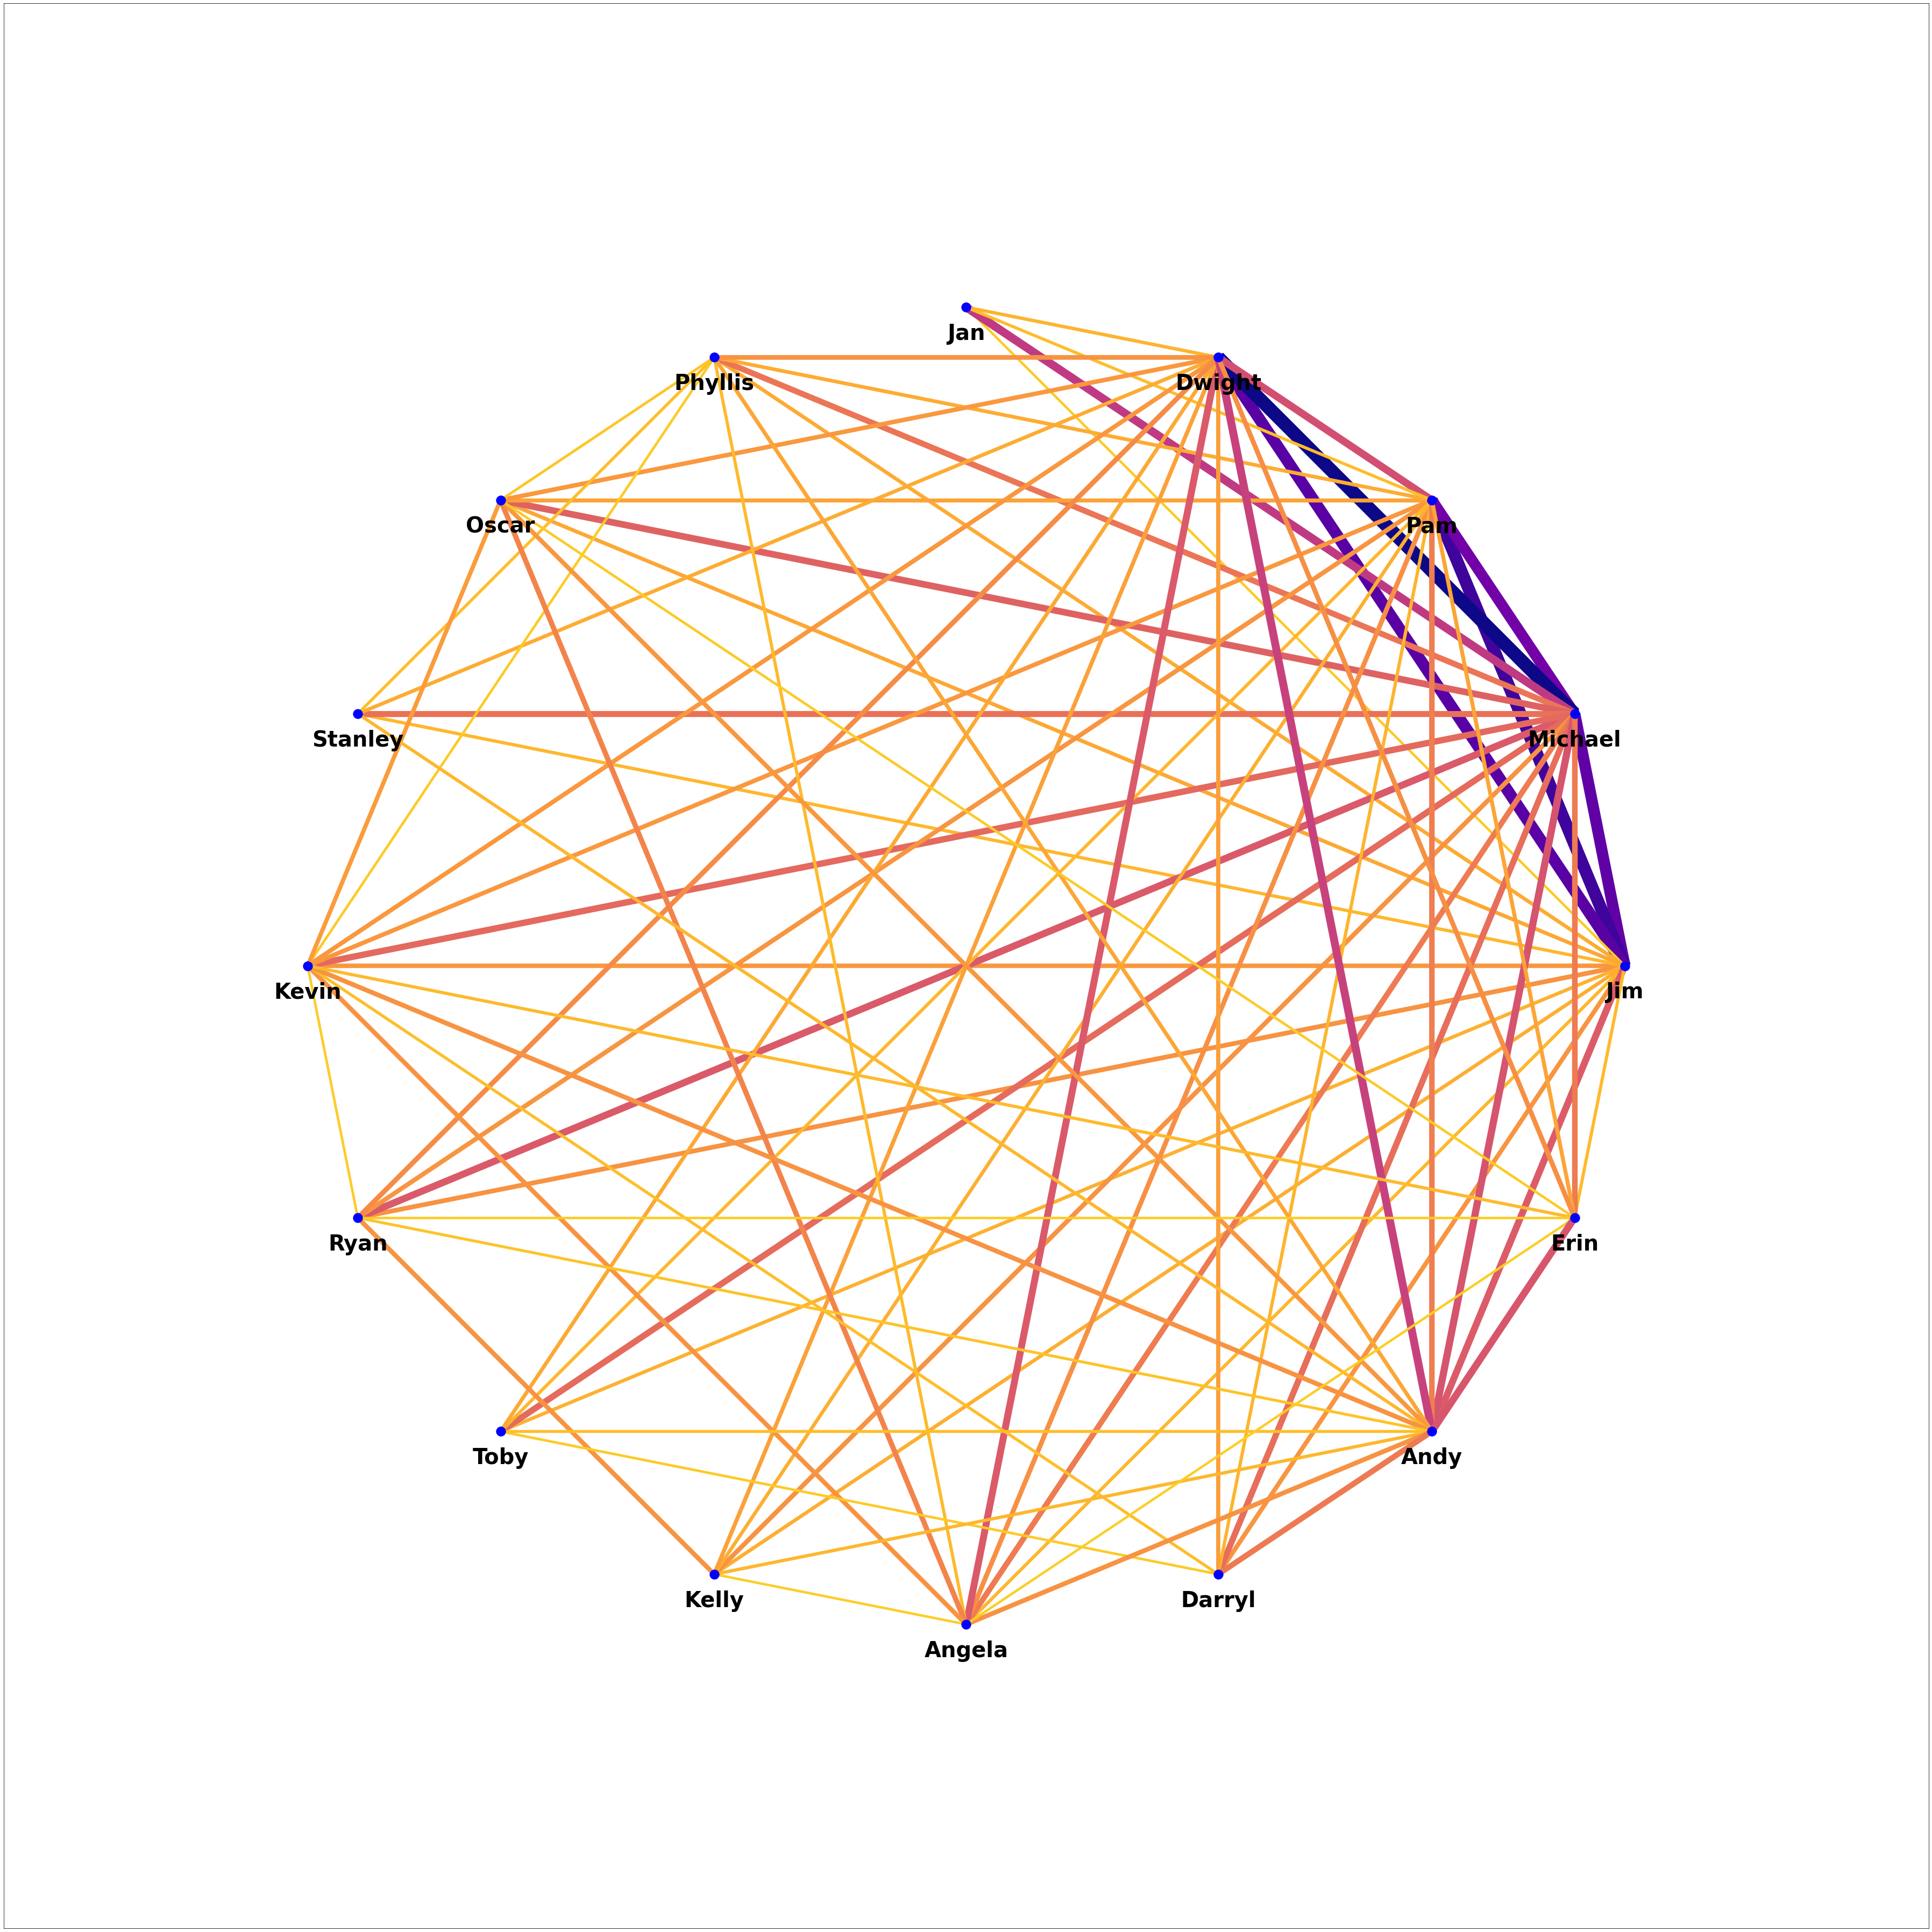

In [51]:
plt.figure(figsize=(50,50))

pos = nx.circular_layout(G) 

edges = G.edges()
colors = [G[u][v]['weight']**0.5 for u,v in edges]
weights = [G[u][v]['weight']**0.4 if G[u][v]['weight'] > 40 else 0 for u,v in edges]

cmap = matplotlib.cm.get_cmap('plasma_r')
nx.draw_networkx(G, pos, width=weights, edge_color=colors, node_color="blue", edge_cmap=cmap, with_labels=False)

labels_pos = {name:[pos_list[0], pos_list[1]-0.04] for name, pos_list in pos.items()}
nx.draw_networkx_labels(G, labels_pos, font_size=40, font_family="sans-serif", font_color="#000000", font_weight="bold")

ax = plt.gca()
ax.margins(0.25)
plt.axis("equal")
plt.tight_layout()
fig = plt.gcf()

## Add Title and Description

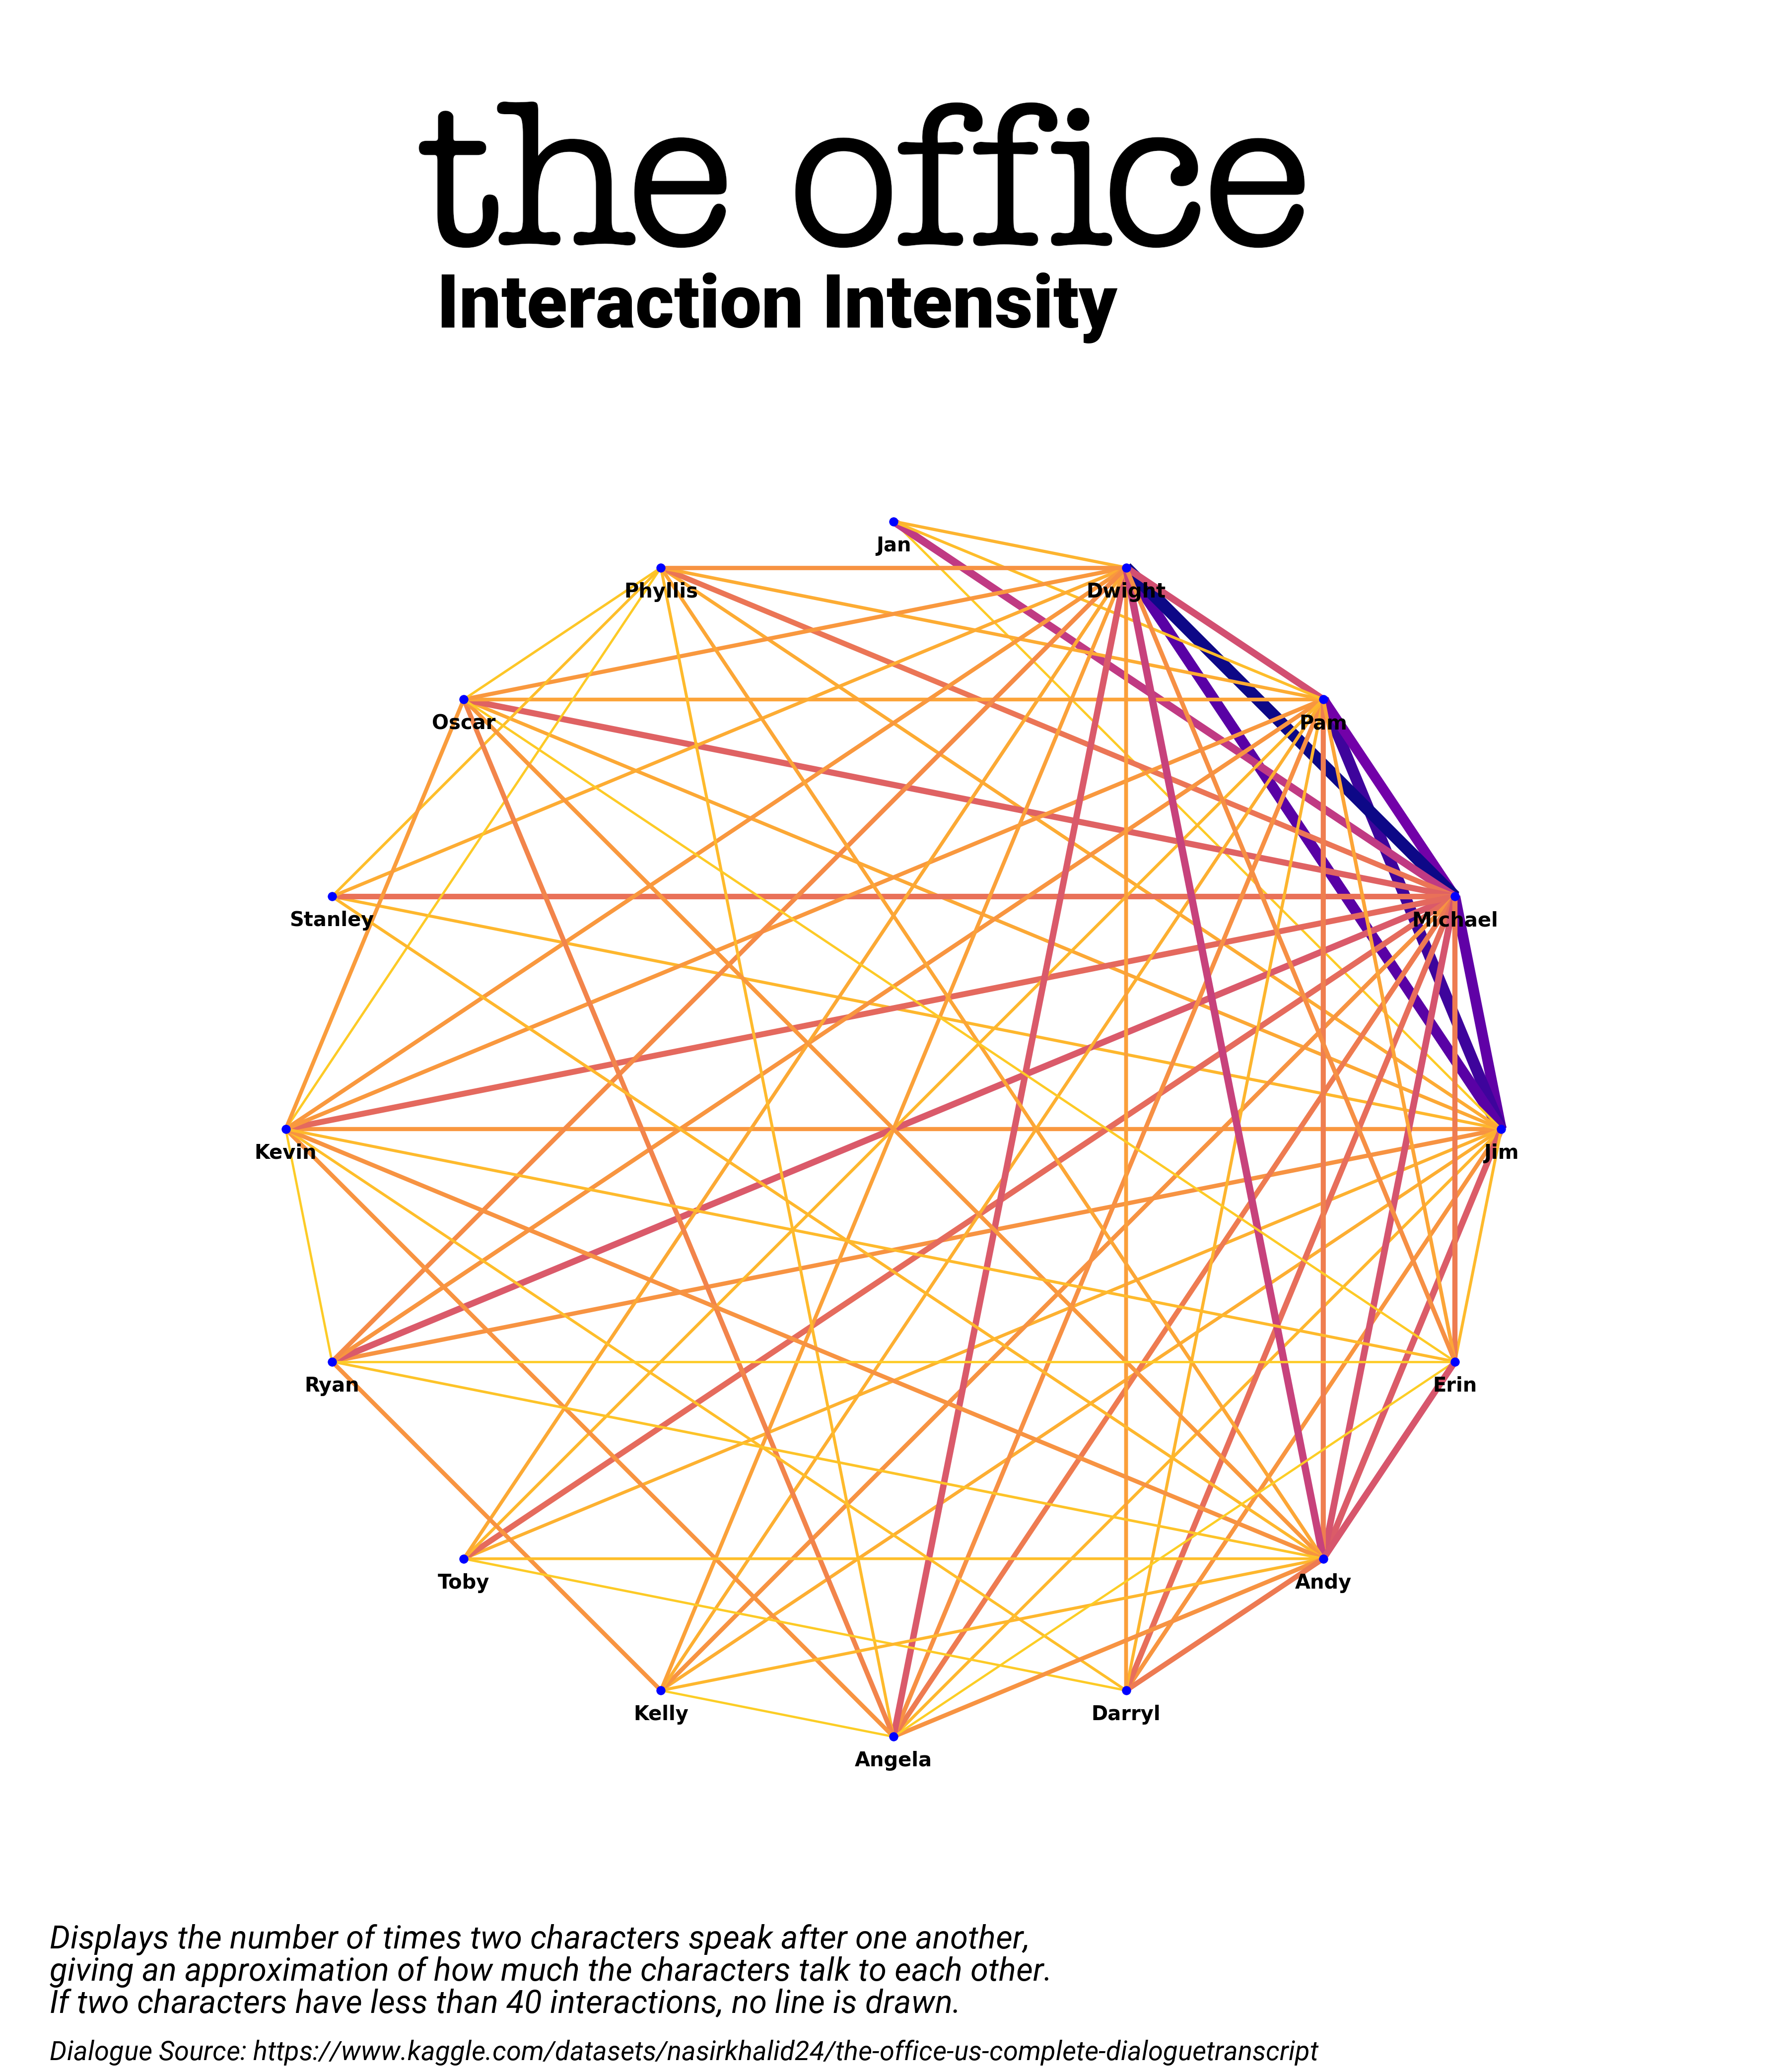

In [86]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

img = fig2img(fig)


# adjust size
width, height = img.size
img = img.crop((25, 25, width-25, height-25))
img = ImageOps.expand(img, (25, 500, 25, 125), fill="white")
draw = ImageDraw.Draw(img)

# add title card
title_card_img = Image.open("./data/title_card.png").convert("RGBA")
width, height = title_card_img.size
title_card_img = title_card_img.resize((int(width * 0.7), int(height * 0.7)), Image.ANTIALIAS)
img.paste(title_card_img, (840, 200), mask=title_card_img)

# add subtitle
font = ImageFont.truetype("./data/roboto/Roboto-Black.ttf", size=150)
draw.text((880, 520),"Interaction Intensity", (0,0,0), font=font)

# add description
font = ImageFont.truetype("./data/roboto/Roboto-Italic.ttf", size=65)
description = \
"""
Displays the number of times two characters speak after one another, 
giving an approximation of how much the characters talk to each other. 
If two characters have less than 40 interactions, no line is drawn. 
"""
draw.text((100, 3800), description, (0,0,0), font=font)

font = ImageFont.truetype("./data/roboto/Roboto-Italic.ttf", size=54)
draw.text((100, 4100), "Dialogue Source: https://www.kaggle.com/datasets/nasirkhalid24/the-office-us-complete-dialoguetranscript", (0,0,0), font=font)


img.save("./connection_graph_text.png")

display(img)